In [18]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import datetime, tqdm

import math

from scipy.spatial import Voronoi, voronoi_plot_2d

from pathlib import Path
import os

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [19]:
#from google.colab import drive
#drive.mount('/content/drive')

In [20]:
#Used if reading from local
train = pd.read_csv("train.csv", low_memory=False)

#Used if reading file from google drive
#train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/w251/train.csv", low_memory=False)

In [21]:
train['ToLeft'] = train.PlayDirection == "left"
train['IsBallCarrier'] = train.NflId == train.NflIdRusher

train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"

train['Dir_rad'] = np.mod(90 - train.Dir, 360) * math.pi/180.0

In [22]:
train['TeamOnOffense'] = "home"
train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"
train['IsOnOffense'] = train.Team == train.TeamOnOffense # Is player on offense?
train['YardLine_std'] = 100 - train.YardLine
train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine_std'
         ] = train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine']
train['X_std'] = train.X
train.loc[train.ToLeft, 'X_std'] = 120 - train.loc[train.ToLeft, 'X'] 
train['Y_std'] = train.Y
train.loc[train.ToLeft, 'Y_std'] = 160/3 - train.loc[train.ToLeft, 'Y'] 

train['Dir_std'] = train.Dir_rad
train.loc[train.ToLeft, 'Dir_std'] = np.mod(np.pi + train.loc[train.ToLeft, 'Dir_rad'], 2*np.pi)

#Added This
train['X_std_centered'] = train.X_std + (50 - train.YardLine_std)

In [23]:
numPlays = int(len(train)/22)
numPlayersPerPlay = 22
test = train[0:numPlayersPerPlay]
test

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,ToLeft,IsBallCarrier,Dir_rad,TeamOnOffense,IsOnOffense,YardLine_std,X_std,Y_std,Dir_std,X_std_centered
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,4.761607,home,False,35,46.09,18.493333,1.620015,61.09
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,4.386012,home,False,35,45.33,20.693333,1.244420,60.33
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,4.315676,home,False,35,46.00,20.133333,1.174083,61.00
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,6.010216,home,False,35,48.54,25.633333,2.868623,63.54
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,4.986231,home,False,35,50.68,17.913333,1.844638,65.68
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,252,03/19/1991,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,6.195744,home,False,35,44.94,29.333333,3.054152,59.94
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-11,190,05/17/1992,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,2.223724,home,False,35,45.89,36.693333,5.365317,60.89
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,193,04/04/1991,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,S

In [24]:
def getPlayData(data, playNum):
    startIndex = playNum * numPlayersPerPlay
    endIndex = startIndex + numPlayersPerPlay
    return data[startIndex:endIndex]

In [15]:
#Used for testing for overlapping players
validCount = 0
for playIndex in range(numPlays):
    playData = getPlayData(train, playIndex)
    coords = []
    for playerIndex in range(len(playData)):
        xCoord = int(round(3 * (playData.iloc[playerIndex]['X_std_centered'] - minPlayerX)))
        yCoord = int(round(3 * playData.iloc[playerIndex]['Y_std']))
        playID = playData.iloc[playerIndex]['PlayId']
        coords.append((xCoord, yCoord))
    #print(len(coords))
    res = list(set(coords))
    #print(len(res))
    if len(res) == numPlayersPerPlay:
        validCount = validCount + 1

print(numPlays)
print(validCount)

31007
30487


In [25]:
maxPlayerX = train['X_std_centered'].max()
minPlayerX = train['X_std_centered'].min()
maxPlayerY = train['Y_std'].max()
minPlayerY = train['Y_std'].min()

In [26]:
print(maxPlayerX)
print(minPlayerX)
print(maxPlayerY)
print(minPlayerY)

108.8
47.019999999999996
56.45
2.69


In [27]:
rangePlayerX = int(round(maxPlayerX - minPlayerX)) + 2

In [28]:
positionValues = train['Position'].unique()
print(positionValues)
encoder = LabelEncoder()
encoder.fit(positionValues)
val = ['LB']
code = encoder.transform(val)
print(code)

['SS' 'DE' 'ILB' 'FS' 'CB' 'DT' 'WR' 'TE' 'T' 'QB' 'RB' 'G' 'C' 'OLB' 'NT'
 'FB' 'MLB' 'LB' 'OT' 'S' 'OG' 'HB' 'DB' 'DL' 'SAF']
[11]


# Example Write

In [12]:
seeExample = True

In [13]:
#fix line of scrimmage. Might just make it flat 50, idk

if seeExample:
    numExamples = 11
    fieldXLen = rangePlayerX
    fieldYLen = 58
    sizeMultiplier = 3
    
    finalFieldXLen = fieldXLen * sizeMultiplier
    finalFieldYLen = fieldYLen * sizeMultiplier + 2
    
    offPlayersRIndex = 0
    runnerGIndex = 1
    defPlayersBIndex = 2
    speedIndex = 3
    accelIndex = 4
    directionIndex = 5
    distanceIndex = 6
    positionIndex = 7
    lineOfScrimmageIndex = 8

    #Required because cells are having weird floating point errors so have to use ints
    numDecimals = 2
    decMultiplier = 10 ^ numDecimals

    imgPath = Path('data.npy')
    labelsPath = Path('labels.npy')

    for playIndex in range(numExamples):
        if playIndex % 100 == 0:
            print(playIndex)

        playData = getPlayData(train, playIndex)
        basicResult = []
        imgResult = []
        coords = []
        for index in range(len(playData)):
            xCoord = round(sizeMultiplier * (playData.iloc[index]['X_std_centered'] - minPlayerX))
            yCoord = round(sizeMultiplier * playData.iloc[index]['Y_std'])
            coords.append((xCoord, yCoord))

        res = list(set(coords))
        playID = 0
        if len(res) == numPlayersPerPlay:
            numAttributes = 9
            fieldData = np.zeros(shape=(finalFieldYLen, finalFieldXLen, numAttributes), dtype = int)
            yardsGained = 0
            actualLineOfScrim = 0
            
            for playerIndex in range(len(playData)):
                playerData = playData.iloc[playerIndex]
                xCoord = int(round(sizeMultiplier * (playerData['X_std_centered'] - minPlayerX)))
                yCoord = int(round(sizeMultiplier * playerData['Y_std']))
                #currentLineOfScrim = int(round(sizeMultiplier * (playerData['YardLine_std'] - minPlayerX)))
                currentLineOfScrim = int(round(sizeMultiplier * (50 - minPlayerX)))
                playID = playerData['PlayId']
                isOnOffense = bool(playerData['IsOnOffense'])
                playerSpeed = playerData['S'] * decMultiplier
                playerAccel = playerData['A'] * decMultiplier
                playerDir = playerData['Dir_std'] * decMultiplier
                playerDist = playerData['Dis'] * decMultiplier
                actualLineOfScrim = playerData['YardLine_std']
                
                playerPos = []
                playerPos.append(playerData['Position'])
                playerPos = int(encoder.transform(playerPos)[0])
                
                isRunner = bool(playerData['IsBallCarrier'])
                yardsGained = playerData['Yards']
                
                if(isRunner):
                    fieldData[yCoord][xCoord][runnerGIndex] = 255
                elif(isOnOffense):
                    fieldData[yCoord][xCoord][offPlayersRIndex] = 255
                else:
                    fieldData[yCoord][xCoord][defPlayersBIndex] = 255

                fieldData[yCoord][xCoord][speedIndex] = playerSpeed
                fieldData[yCoord][xCoord][accelIndex] = playerAccel
                fieldData[yCoord][xCoord][directionIndex] = playerDir
                fieldData[yCoord][xCoord][distanceIndex] = playerDist
                fieldData[yCoord][xCoord][positionIndex] = playerPos
                #print(fieldData[yCoord][xCoord][directionIndex])
            
            fieldData[:, currentLineOfScrim, lineOfScrimmageIndex] = actualLineOfScrim
            
            write = True
            if(write):
                with imgPath.open('ab') as f:
                    dataToWrite = fieldData
                    np.save(f, dataToWrite)
                    #print(dataToWrite.shape)

                with labelsPath.open('ab') as f:
                    np.save(f, int(yardsGained))

0


# Example Data Read

In [14]:
#reading in all of the data
if seeExample:
    sampleData = []
    with imgPath.open('rb') as f:
        fsz = os.fstat(f.fileno()).st_size
        out = np.load(f)
        sampleData.append(out)
        while f.tell() < fsz:
            sampleData.append(np.load(f))
    
    sampleData = np.asarray(sampleData)
    print(sampleData.shape)

(10, 176, 192, 9)


In [15]:
#grab first play of data
if seeExample:
    img = sampleData[0]
    print(img.shape)

(176, 192, 9)


In [16]:
#grabbing RGB values from data and transposing them to fit the requirements of plt.imshow
if seeExample:
    newImg = img[:,:,0:3]
    print(newImg.shape)

(176, 192, 3)


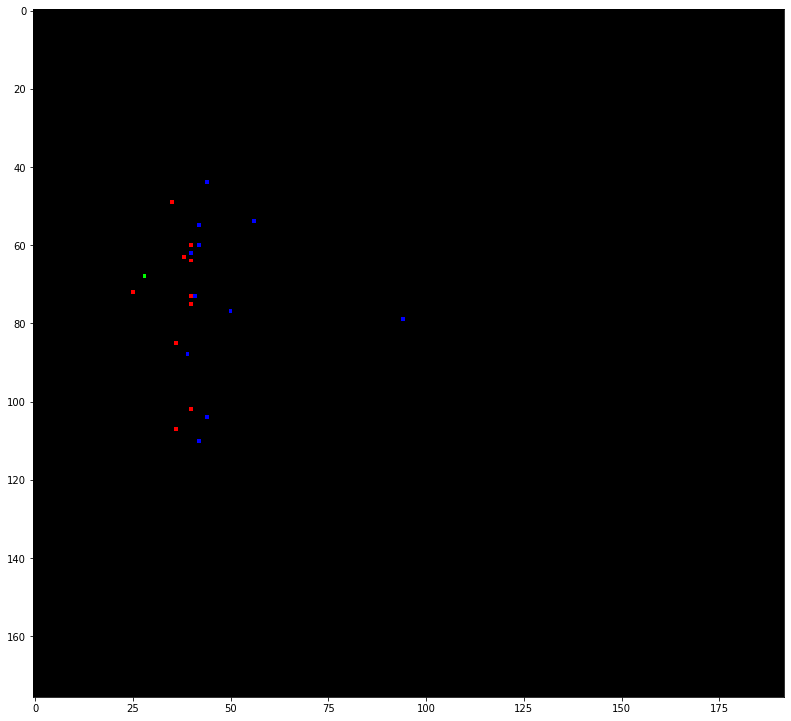

In [17]:
if seeExample:
    fig, ax = plt.subplots(1, figsize=(12*2, 6.33*2))
    plt.imshow(newImg)

# Example Label Read

In [180]:
#Getting Label
if seeExample:
    labels = []
    with labelsPath.open('rb') as f:
        fsz = os.fstat(f.fileno()).st_size
        out = np.load(f)
        labels.append(out)
        while f.tell() < fsz:
            labels.append(np.load(f))
    
    labels = np.asarray(labels)
    print(labels.shape)

(10,)


In [181]:
firstLabel = labels[0]
secondLabel = labels[1]
print(firstLabel)
print(secondLabel)

8
3


# Real Write, will take a long time to run, will also eat your hard drive. Don't run in Colab, not enough disk space allowance

In [30]:
wantToWrite = True
if wantToWrite:
    fieldXLen = rangePlayerX
    fieldYLen = 58
    sizeMultiplier = 3
    numWrites = 0
    
    finalFieldXLen = fieldXLen * sizeMultiplier
    finalFieldYLen = fieldYLen * sizeMultiplier + 2
    
    offPlayersRIndex = 0
    runnerGIndex = 1
    defPlayersBIndex = 2
    speedIndex = 3
    accelIndex = 4
    directionIndex = 5
    distanceIndex = 6
    positionIndex = 7
    lineOfScrimmageIndex = 8

    #Required because cells are having weird floating point errors so have to use ints
    numDecimals = 2
    decMultiplier = 10 ^ numDecimals

    imgPath = Path('full_data.npy')
    labelsPath = Path('full_labels.npy')

    for playIndex in range(numPlays):
        if playIndex % 100 == 0:
            print(playIndex)

        playData = getPlayData(train, playIndex)
        basicResult = []
        imgResult = []
        coords = []
        for index in range(len(playData)):
            xCoord = round(sizeMultiplier * (playData.iloc[index]['X_std_centered'] - minPlayerX))
            yCoord = round(sizeMultiplier * playData.iloc[index]['Y_std'])
            coords.append((xCoord, yCoord))

        res = list(set(coords))
        playID = 0
        if len(res) == numPlayersPerPlay:
            numAttributes = 9
            fieldData = np.zeros(shape=(finalFieldYLen, finalFieldXLen, numAttributes), dtype = int)
            yardsGained = 0
            actualLineOfScrim = 0
            write = True
            
            try:
                for playerIndex in range(len(playData)):
                    playerData = playData.iloc[playerIndex]
                    xCoord = int(round(sizeMultiplier * (playerData['X_std_centered'] - minPlayerX)))
                    yCoord = int(round(sizeMultiplier * playerData['Y_std']))
                    #currentLineOfScrim = int(round(sizeMultiplier * (playerData['YardLine_std'] - minPlayerX)))
                    currentLineOfScrim = int(round(sizeMultiplier * (50 - minPlayerX)))
                    playID = playerData['PlayId']
                    isOnOffense = bool(playerData['IsOnOffense'])
                    playerSpeed = playerData['S'] * decMultiplier
                    playerAccel = playerData['A'] * decMultiplier
                    playerDir = playerData['Dir_std'] * decMultiplier
                    playerDist = playerData['Dis'] * decMultiplier
                    actualLineOfScrim = playerData['YardLine_std']

                    playerPos = []
                    playerPos.append(playerData['Position'])
                    playerPos = int(encoder.transform(playerPos)[0])

                    isRunner = bool(playerData['IsBallCarrier'])
                    yardsGained = playerData['Yards']

                    if(isRunner):
                        fieldData[yCoord][xCoord][runnerGIndex] = 255
                    elif(isOnOffense):
                        fieldData[yCoord][xCoord][offPlayersRIndex] = 255
                    else:
                        fieldData[yCoord][xCoord][defPlayersBIndex] = 255

                    fieldData[yCoord][xCoord][speedIndex] = playerSpeed
                    fieldData[yCoord][xCoord][accelIndex] = playerAccel
                    fieldData[yCoord][xCoord][directionIndex] = playerDir
                    fieldData[yCoord][xCoord][distanceIndex] = playerDist
                    fieldData[yCoord][xCoord][positionIndex] = playerPos
                    #print(fieldData[yCoord][xCoord][directionIndex])

                fieldData[:, currentLineOfScrim, lineOfScrimmageIndex] = actualLineOfScrim
            except:
                print("There was an error")
                write = False
            
            
            if(write):
                with imgPath.open('ab') as f:
                    dataToWrite = fieldData
                    np.save(f, dataToWrite)
                    numWrites = numWrites + 1

                with labelsPath.open('ab') as f:
                    np.save(f, int(yardsGained))
            write = True

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
13400
There was an error
There was an error
There was an error
13500
13600
13700
13800
13900
14000


In [31]:
print(str(numWrites))

30467
